# 라이브러리 호출

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import random

# resnet의 layer 선언

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.GELU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

# fake image를 만들어 내는 generateor

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), 
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.GELU(),
        )
        self.m = nn.Sigmoid()
        
        channels = out_channels
        
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.GELU(),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        self.up = []
        
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.GELU(),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

# 진짜 image인지 가짜 image인지 구분 

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False),
            *self.block(64, 128),  
            *self.block(128, 256), 
            *self.block(256, 512),
            
            nn.ZeroPad2d((1,0,1,0)), 
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
        self.scale_factor = 16
        self.m = nn.Sigmoid()
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        x = self.model(x)
        x = self.m(x)
        return x
    

# loss funtion 선언

In [5]:
criterion_GAN = nn.BCELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.MSELoss()

# model 선언

In [6]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [7]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


# optimizer 선언

In [8]:
import itertools
lr = 0.0002


optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr , betas = (0.5,0.999)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr , betas = (0.5,0.999)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr , betas = (0.5,0.999)
)

In [9]:
n_epoches = 300
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

# dataset 호출 함수

In [10]:
class Dataset(object):
    def __init__(self, label_dir, input_dir, image_size, scale):
        self.label_dir = [os.path.join(label_dir, x) for x in os.listdir(label_dir) if self.check_image_file(x)]
        self.input_dir = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if self.check_image_file(x)]
        self.image_size = image_size
        self.to_Tensor = transforms.ToTensor()
        self.resize = transforms.Resize((128 , 128 ), interpolation=Image.BICUBIC)
        self.rotates = [0, 90, 180, 270]
    
    def check_image_file(self, filename: str):
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG", ".BMP"])
    
    def data_augmentation(self, hr, lr):

        width, height = hr.size
        
        hr = hr.resize((320, 180), resample=Image.BICUBIC)
        lr = lr.resize((320, 180), resample=Image.BICUBIC)
    
        return hr, lr

    def __getitem__(self, idx):
    
    
        hr = Image.open(self.label_dir[idx]).convert("RGB")
        lr = Image.open(self.input_dir[idx]).convert("RGB") 

        hr, lr = self.data_augmentation(hr, lr) 
        
        return self.to_Tensor(hr), self.to_Tensor(lr) 

    def __len__(self):
        return len(self.label_dir)

In [11]:
class TestDataset(object):
    def __init__(self, label_dir, input_dir, image_size, scale):
        self.label_dir = [os.path.join(label_dir, x) for x in os.listdir(label_dir) if self.check_image_file(x)]
        self.input_dir = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if self.check_image_file(x)]
        self.image_size = image_size
        self.to_Tensor = transforms.ToTensor()
        self.resize = transforms.Resize((image_size , image_size ), interpolation=Image.BICUBIC)
        self.rotates = [0, 90, 180, 270]
     
    
    def check_image_file(self, filename: str):
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG", ".BMP"])
    

    def data_augmentation(self, hr, lr):

        width, height = hr.size

        hr = hr.resize((320, 180), resample=Image.BICUBIC)
        lr = lr.resize((320, 180), resample=Image.BICUBIC)

        return hr, lr

    def __getitem__(self, idx):

        hr = Image.open(self.label_dir[idx]).convert("RGB") 
        lr = Image.open(self.input_dir[idx]).convert("RGB") 

 
        hr, lr = self.data_augmentation(hr, lr) 
        return self.to_Tensor(hr), self.to_Tensor(lr) 

    def __len__(self):
        return len(self.label_dir)

In [12]:
train_dir = '/data/chgo/밤'
label_dir = '/data/chgo/낮'

In [13]:
#test_dir = '/data/chgo/낮'
#test_label_dir = '/data/chgo/밤'

In [14]:
train_dataset = Dataset(train_dir , label_dir,256,1)

In [15]:
test_dataset = TestDataset(train_dir ,label_dir,256,1)

In [16]:
len(train_dataset)

4000

In [17]:
train_dataset[1][1]

tensor([[[0.8431, 0.8431, 0.8471,  ..., 0.6863, 0.6784, 0.6784],
         [0.8431, 0.8431, 0.8471,  ..., 0.6941, 0.6863, 0.6863],
         [0.8353, 0.8353, 0.8549,  ..., 0.7059, 0.7020, 0.7020],
         ...,
         [0.2824, 0.3255, 0.3294,  ..., 0.2392, 0.2353, 0.2353],
         [0.3098, 0.3294, 0.3255,  ..., 0.2353, 0.2353, 0.2353],
         [0.2941, 0.3137, 0.3020,  ..., 0.2353, 0.2353, 0.2353]],

        [[0.9529, 0.9529, 0.9569,  ..., 0.8000, 0.7922, 0.7922],
         [0.9529, 0.9529, 0.9569,  ..., 0.8078, 0.8000, 0.8000],
         [0.9451, 0.9451, 0.9647,  ..., 0.8196, 0.8196, 0.8196],
         ...,
         [0.3373, 0.3804, 0.3843,  ..., 0.2941, 0.2902, 0.2902],
         [0.3647, 0.3843, 0.3804,  ..., 0.2902, 0.2902, 0.2902],
         [0.3490, 0.3686, 0.3569,  ..., 0.2902, 0.2902, 0.2902]],

        [[0.9569, 0.9569, 0.9608,  ..., 0.7922, 0.7843, 0.7843],
         [0.9569, 0.9569, 0.9608,  ..., 0.8000, 0.7922, 0.7922],
         [0.9490, 0.9490, 0.9686,  ..., 0.8118, 0.8118, 0.

In [18]:
transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [19]:
train_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4
)



In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size = 2,
    shuffle = True
)

In [21]:
len(train_loader)

1000

# real image와 fake image를 시각화

In [22]:
from torchvision.utils import make_grid
import random
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()
    reconv_A = G_BA(fake_B).detach()
    '''
    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()
'''
    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(reconv_A, nrow=nrows, normalize=True)
    #fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(30, 15))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

torch.Size([4, 3, 180, 320])
torch.Size([4, 3, 180, 320])


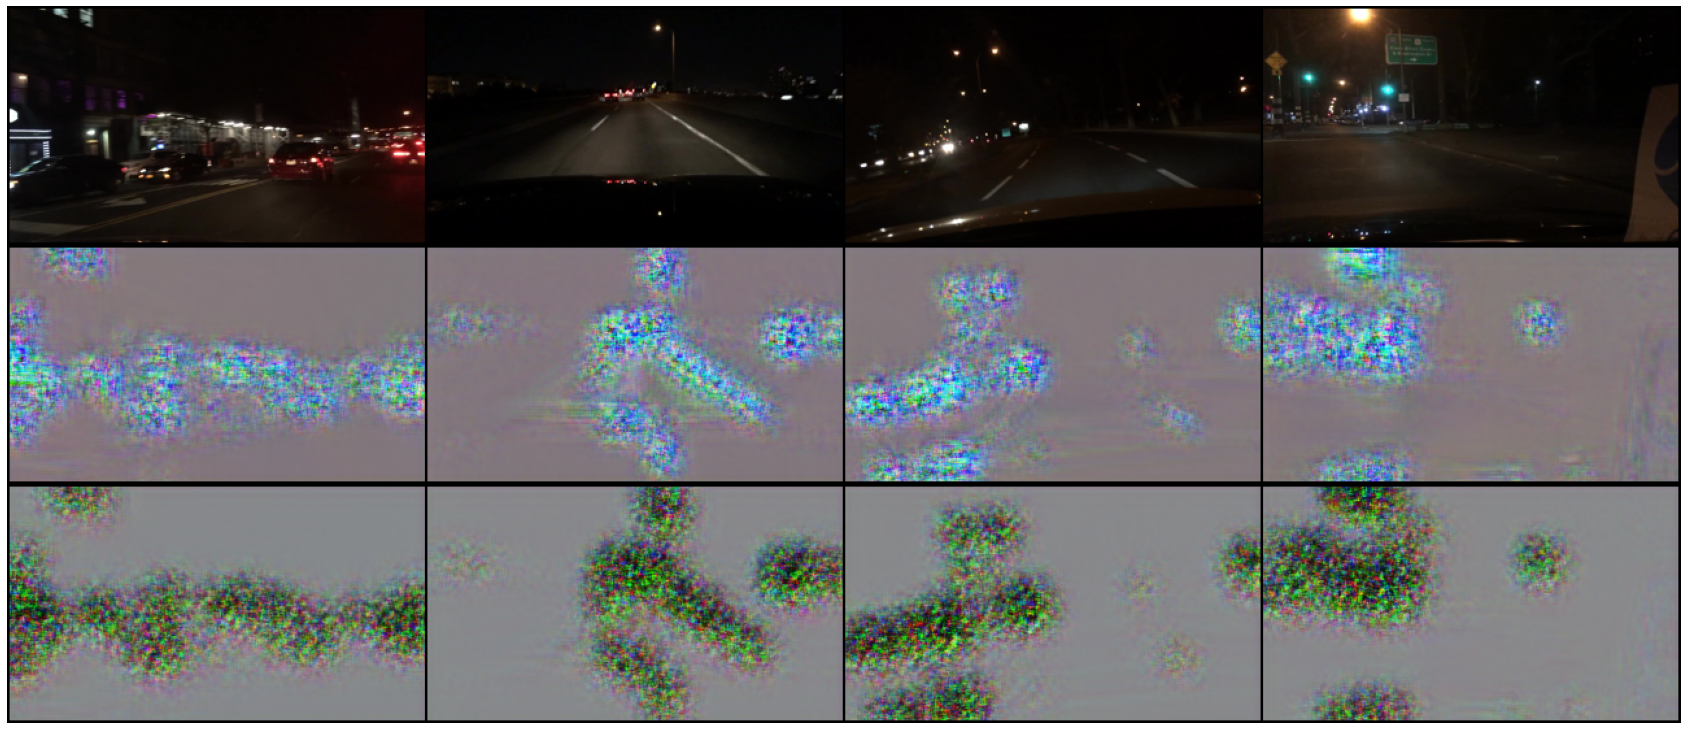

In [23]:
real_A, real_B = next(iter(train_loader))
print(real_A.shape)
print(real_B.shape)
sample_images(real_A, real_B)

In [24]:
real_A, real_B = next(iter(train_loader))
fake_B = G_AB(real_A.cuda())
reconv_A = G_BA(fake_B).detach().cuda()

fake_B

tensor([[[[0.5198, 0.5245, 0.5252,  ..., 0.5183, 0.5179, 0.5201],
          [0.5198, 0.5232, 0.5213,  ..., 0.5159, 0.5152, 0.5189],
          [0.5170, 0.5244, 0.5255,  ..., 0.5186, 0.5158, 0.5193],
          ...,
          [0.5177, 0.5247, 0.5336,  ..., 0.5156, 0.5118, 0.5188],
          [0.5188, 0.5293, 0.5357,  ..., 0.5156, 0.5119, 0.5147],
          [0.5211, 0.5331, 0.5345,  ..., 0.5167, 0.5130, 0.5133]],

         [[0.4906, 0.4874, 0.4923,  ..., 0.4891, 0.4871, 0.5007],
          [0.4872, 0.4851, 0.4916,  ..., 0.4868, 0.4842, 0.4949],
          [0.4976, 0.4899, 0.4971,  ..., 0.4894, 0.4899, 0.5028],
          ...,
          [0.4847, 0.4871, 0.4927,  ..., 0.4755, 0.4747, 0.4856],
          [0.4935, 0.4923, 0.5000,  ..., 0.4897, 0.4883, 0.5013],
          [0.4952, 0.4936, 0.4961,  ..., 0.4905, 0.4876, 0.5022]],

         [[0.5073, 0.5140, 0.5081,  ..., 0.5105, 0.5032, 0.5134],
          [0.5065, 0.5079, 0.5066,  ..., 0.5105, 0.5067, 0.5136],
          [0.5101, 0.5172, 0.5169,  ..., 0

# train

In [25]:
torch.manual_seed(777)

from tqdm.notebook import tqdm

for epoch in range(n_epoches):
    for i, (real_A, real_B) in tqdm(enumerate(train_loader),total = len(train_loader)):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        G_AB.train()
        G_BA.train()
        D_A.train()
        D_B.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A) 
        fake_A = G_BA(real_B)  
        
        loss_id_A = torch.sqrt(criterion_identity(fake_B, real_A)) 
        loss_id_B = torch.sqrt(criterion_identity(fake_A, real_B))
        loss_identity = (loss_id_A + loss_id_B) / 2

        loss_GAN_AB = criterion_GAN(D_B(fake_B),valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        loss_G = 5.0 *loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
        
        if (epoch+1) % 10 == 0:
            torch.save(G_AB.state_dict(), 'G_AB2.pth')
            torch.save(G_BA.state_dict(), 'G_BA2.pth')
            torch.save(D_A.state_dict(), 'D_A2.pth')
            torch.save(D_B.state_dict(), 'D_B2.pth')
            
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
 
    test_real_A, test_real_B = next(iter(test_loader))
    sample_images(test_real_A, test_real_B)

    loss_D = (loss_D_A + loss_D_B) / 2
    print(f'[Epoch {epoch+1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
    print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]') 

KeyboardInterrupt: 

In [ ]:
real_A, real_B = next(iter(test_loader))
print(real_A.shape)
print(real_B.shape)
sample_images(real_A, real_B)

In [ ]:
'''
real_A, real_B = next(iter(test_loader))

print(real_A.shape)
print(real_B.shape)
sample_images(real_A, real_B)
'''